# Regression ABC using MDNs
MDN implementation based on this tutorial: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from pyabc.examples import tuberculosis
import pyabc

from regression_abc import MDN, mdn_loss_function

import torch
from torch.autograd import Variable
import torch.nn as nn

## GMM example
Let's first consider the simple example of an equally weighted mixture of Gaussians with equal mean. One of them with a std of 1, the other 0.1.

In [2]:
def simulator(mu):
    if np.random.rand() < 0.5:
        return np.random.normal(mu,1)
    else:
        return np.random.normal(mu,0.1)
    
def posterior(mu):
    return 0.5 * ss.norm.pdf(mu, 0, 1) + 0.5 * ss.norm.pdf(mu, 0, 0.1)

<IPython.core.display.Javascript object>


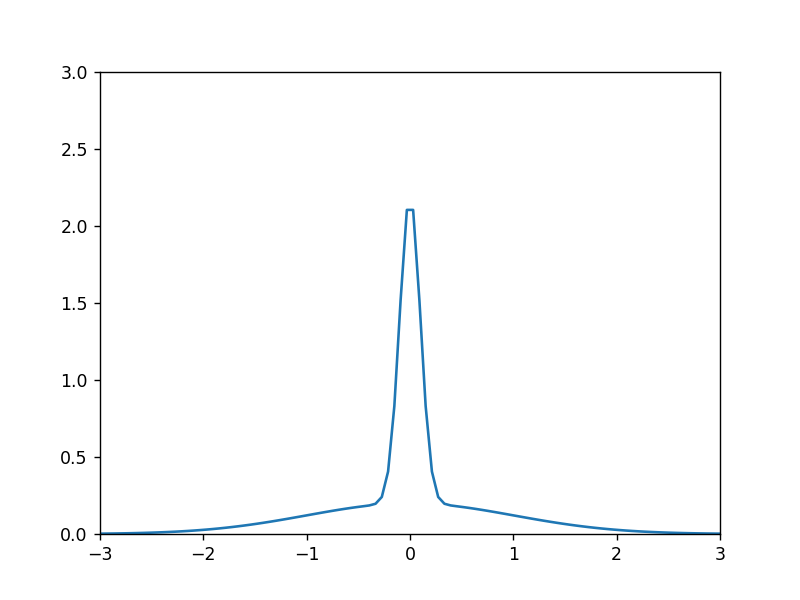

In [3]:
xx = np.linspace(-3,3,100)
plt.figure()
plt.plot(xx, posterior(xx))
plt.xlim((-3,3))
plt.ylim((0,3))
plt.show()

In [12]:
x_obs = 0.0

We use a uniform prior and generate 2500 samples, from which we generate the training set for our MDN.

In [4]:
NSAMPLE = 10_000

theta = np.random.uniform(-2, 4, NSAMPLE)
theta.shape

(10000,)

In [5]:
x_data = np.array([simulator(theta_i) for theta_i in theta])
#x_data = summarize(x)
x_data.shape

(10000,)

Here, we adjust the number of hidden units and mixture components in the MDN

In [6]:
NHIDDEN = 20 # hidden units
KMIX = 2 # number of mixtures

Convert the training examples to torch tensors.

In [7]:
x_train = Variable(torch.from_numpy(x_data.reshape(NSAMPLE, 1)).float())
theta_train = Variable(torch.from_numpy(theta.reshape(NSAMPLE, 1)).float(), requires_grad=False)

<IPython.core.display.Javascript object>


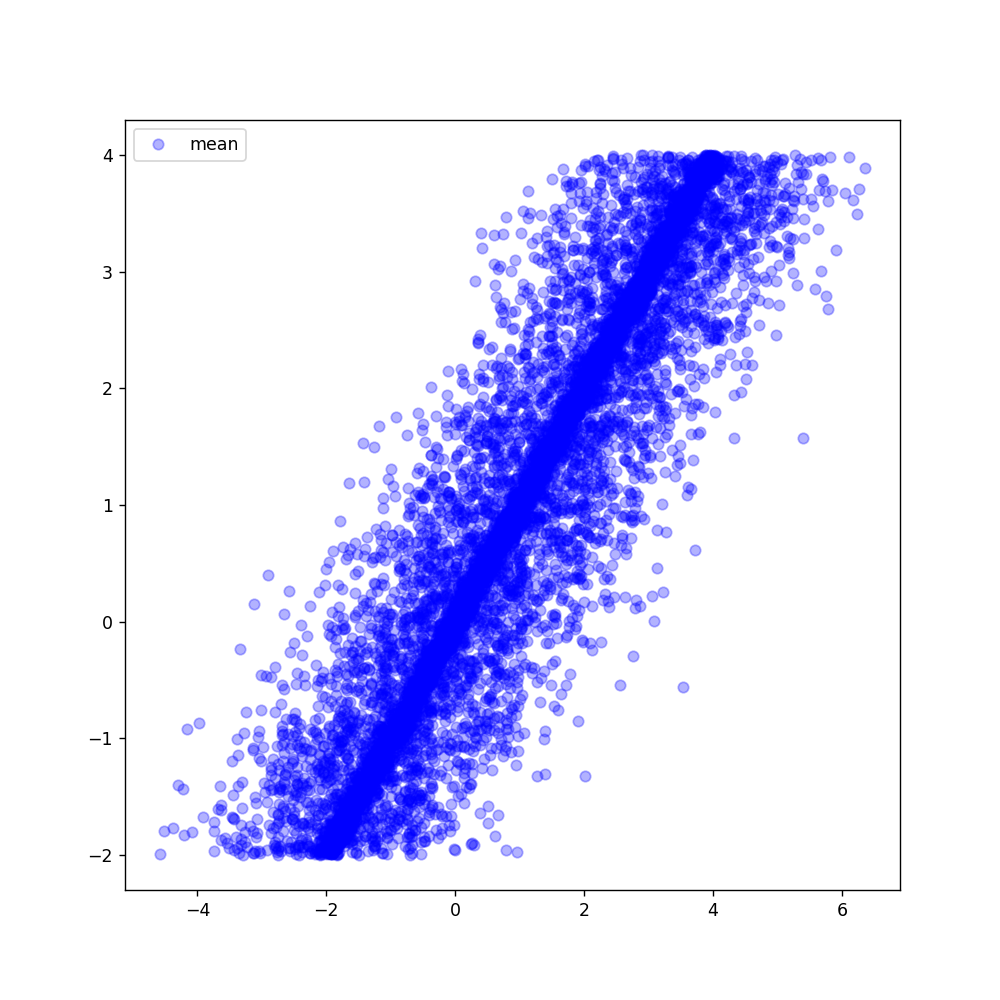

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(x_train.data.numpy()[:,0],theta_train.data.numpy(),'bo', alpha=0.3, label='mean')
#plt.plot(x_train.data.numpy()[:,1],theta_train.data.numpy(),'ro', alpha=0.3, label='std')
plt.legend()
plt.show()

We now define the loss function, which is simply the negative log likelihood of the training data under our model.

In [9]:
model = MDN(hidden_size=NHIDDEN, num_mixtures=KMIX, input_dim=1)

In [10]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(10000):
    (out_pi, out_sigma, out_mu) = model(x_train)
    loss = mdn_loss_function(out_pi, out_sigma, out_mu, theta_train)
    if (t % 500 == 0):
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 1.9425296783447266
500 0.7321802377700806
1000 0.5909801125526428
1500 0.5811255574226379
2000 0.5710649490356445
2500 0.5660894513130188
3000 0.563031017780304
3500 0.5607360601425171
4000 0.5584441423416138
4500 0.5559579133987427
5000 0.553797721862793
5500 0.5520129203796387
6000 0.5504454970359802
6500 0.5488664507865906
7000 0.5471681356430054
7500 0.5453067421913147
8000 0.5433757901191711
8500 0.5414966344833374
9000 0.5399569272994995
9500 0.5389894247055054


In [13]:
x_test = Variable(torch.from_numpy(np.array(x_obs).reshape(1, 1)).float())

In [14]:
xx = np.linspace(-3,3,100)

In [15]:
pdf = model.pdf(x_test, xx)

In [16]:
pdf.shape

(100,)

<IPython.core.display.Javascript object>


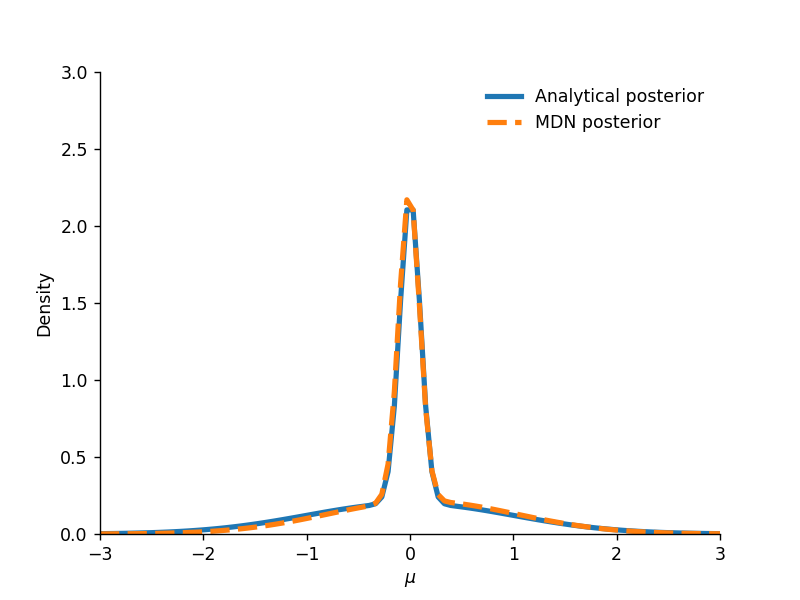

In [17]:
xx = np.linspace(-3,3,100)
f, ax = plt.subplots()
ax.plot(xx, posterior(xx), label='Analytical posterior', linewidth=3)
ax.plot(xx, pdf, label='MDN posterior', linewidth=3, linestyle='--')
ax.set_xlim((-3,3))
ax.set_ylim((0,3))
ax.legend(frameon=False)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel('Density')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('regression_abc_gmm.pdf')

## Tuberculosis example

In [18]:
alpha = 0.2
delta = 0
tau = 0.198
m = 20
N = 2e7

prior_alpha = pyabc.Prior("uniform", 0.005, 2, name=r"$\alpha$")
#prior_tau = pyabc.Prior("uniform", 0.01, 1, name="$\tau$")

list_of_priors = [prior_alpha]

simulator = tuberculosis.simulator

params = [alpha, tau, delta]

y0 = np.array([6,3,2,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0]) # from paper

# read reference (rejection ABC) posterior
rej = pyabc.RejectionSampler.load('/home/dominik/Dropbox/Studium/AppliedCognitiveModelling2017/ABC/03 data/ex02/rej_10000_0.pkl')
rej.Thetas

xx = np.linspace(-0.2, 1.2, 100)

rej_thetas = rej.Thetas[:,0]
rej_kde = ss.kde.gaussian_kde(rej_thetas)
rej_dens = rej_kde(xx)

In [19]:
# create training set
NSAMPLE = 5000
INPUT_DIM = 20

# create training set
alpha_train = prior_alpha.sample(size=NSAMPLE)
x_train = np.array([simulator(float(alpha_i)) for alpha_i in alpha_train])

x_train = Variable(torch.from_numpy(x_train.reshape(NSAMPLE, INPUT_DIM)).float())
theta_train = Variable(torch.from_numpy(alpha_train.reshape(NSAMPLE, 1)).float(), requires_grad=False)

# 'test example' (observed data point)
x_test = Variable(torch.from_numpy(np.array(y0).reshape(1, INPUT_DIM)).float())

KeyboardInterrupt: 

In [23]:
NHIDDEN = 30
KMIX = 3

model = MDN(hidden_size=NHIDDEN, num_mixtures=KMIX, input_dim=INPUT_DIM)

<IPython.core.display.Javascript object>


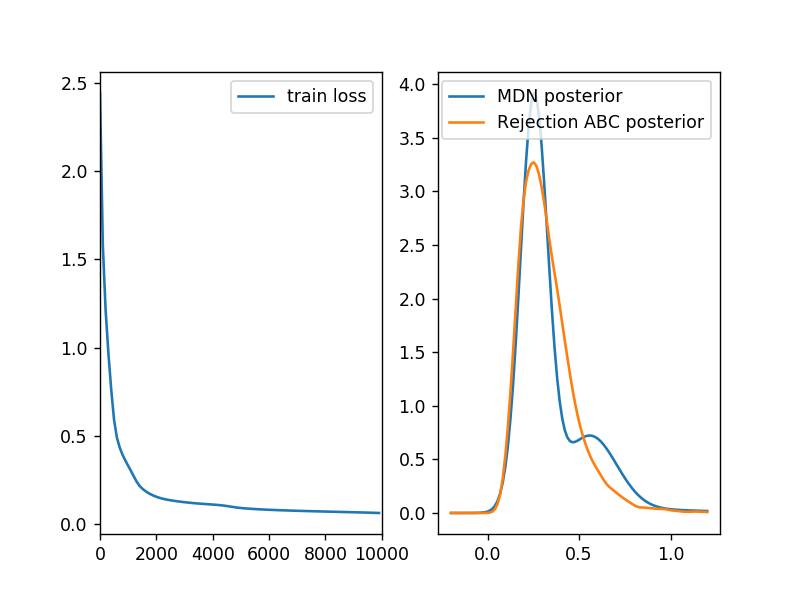

0 2.444700241088867
100 1.5821627378463745
200 1.209624171257019
300 0.9632428884506226
400 0.7569864988327026
500 0.5879156589508057
600 0.4885239899158478
700 0.43182337284088135
800 0.39108771085739136
900 0.35815927386283875
1000 0.32859519124031067
1100 0.29903659224510193
1200 0.26818814873695374
1300 0.23843036592006683
1400 0.2153007686138153
1500 0.19896598160266876
1600 0.18626193702220917
1700 0.1757066547870636
1800 0.166707381606102
1900 0.1590554267168045
2000 0.15264149010181427
2100 0.14728064835071564
2200 0.142777681350708
2300 0.13895775377750397
2400 0.13567067682743073
2500 0.1327977478504181
2600 0.13024525344371796
2700 0.12793193757534027
2800 0.12579327821731567
2900 0.12378930300474167
3000 0.12190253287553787
3100 0.12013085931539536
3200 0.11847928166389465
3300 0.11695126444101334
3400 0.1155417263507843
3500 0.11423572897911072
3600 0.11301199346780777
3700 0.11184681206941605
3800 0.11071564257144928
3900 0.10959173738956451
4000 0.10844229906797409
4100 

In [25]:
f, (loss_ax, dens_ax) = plt.subplots(1,2)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []
for t in range(10_000):
    (out_pi, out_sigma, out_mu) = model(x_train)
    loss = mdn_loss_function(out_pi, out_sigma, out_mu, theta_train)        
    if (t % 100 == 0):
        train_loss.append(loss.data[0])
        loss_ax.cla()
        loss_ax.plot(np.arange(t+1, step=100), train_loss, label="train loss")
        loss_ax.set_xlim((0,10_000))
        loss_ax.legend()
        
        dens_ax.cla()
        dens_ax.plot(xx, model.pdf(x_test, xx), label='MDN posterior')
        dens_ax.plot(xx, rej_dens, label='Rejection ABC posterior')
        dens_ax.legend()
        
        f.canvas.draw()
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

<IPython.core.display.Javascript object>


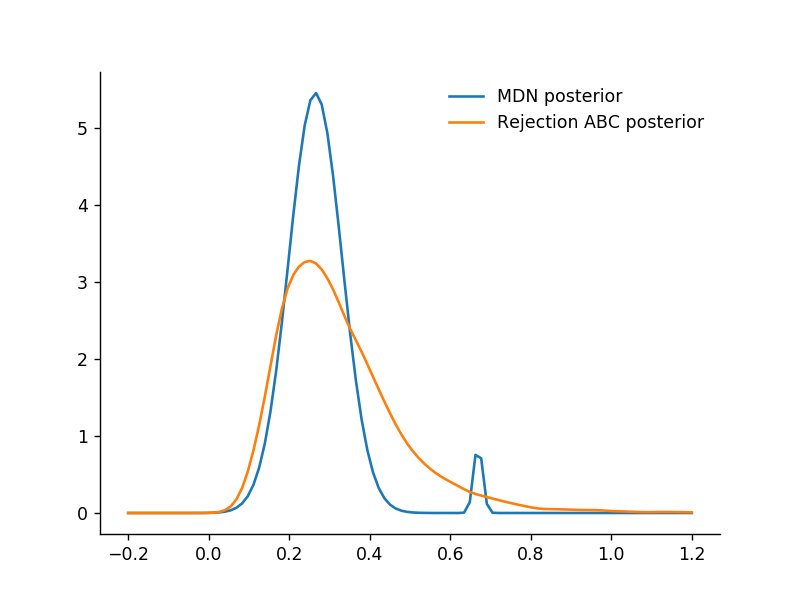

In [92]:
pdf = model.pdf(x_test, xx)

f, ax = plt.subplots()
ax.plot(xx, pdf, label='MDN posterior')
ax.plot(xx, rej_dens, label='Rejection ABC posterior')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.legend(frameon=False)